# Lab 6

In [21]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [22]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1 - Population Growth Rate

In [23]:
q1_sql = """
SELECT 
    p.year,
    p.pop,
    ROUND(
        (p.pop::numeric - LAG(p.pop) OVER (PARTITION BY n.name ORDER BY p.year)) 
        / LAG(p.pop) OVER (PARTITION BY n.name ORDER BY p.year) * 100, 
        2
    ) AS yoy_growth_rate_percent
FROM 
    public.population p
JOIN 
    public.name n ON p.fips = n.fips
WHERE 
    n.name = 'New Mexico'
ORDER BY 
    p.year;
"""

In [24]:
import pandas as pd
q1_df = pd.read_sql_query(q1_sql, con=conn)
print(q1_df.head(5))

   year      pop  yoy_growth_rate_percent
0  2005  1887200                      NaN
1  2006  1954599                     3.57
2  2007  1969915                     0.78
3  2008  1984356                     0.73
4  2009  2009671                     1.28


/tmp/ipykernel_7771/1088107709.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q1_df = pd.read_sql_query(q1_sql, con=conn)


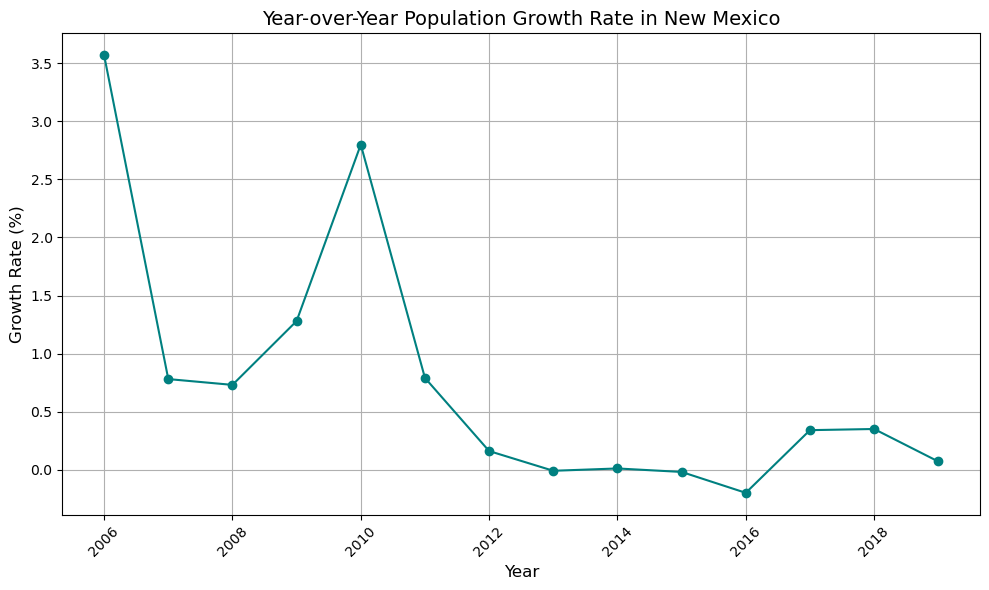

In [25]:
import matplotlib.pyplot as plt

df = q1_df.dropna(subset=['yoy_growth_rate_percent'])

plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['yoy_growth_rate_percent'], marker='o', linestyle='-', color='teal')

plt.title('Year-over-Year Population Growth Rate in New Mexico', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Growth Rate (%)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


Population growth rate dropped starting in 2010, with a small increase starting in 2016.

## Q2 - Income and Population Relationship

In [26]:
import pandas as pd

q2_sql = """
SELECT 
    i.year,
    i.income,
    p.pop
FROM 
    public.income i
JOIN 
    public.population p ON i.fips = p.fips AND i.year = p.year
JOIN 
    public.name n ON i.fips = n.fips
WHERE 
    n.name = 'New Mexico'
ORDER BY 
    i.year;
"""

q2_df = pd.read_sql_query(q2_sql, con=conn)
print(q2_df.head())


   year  income      pop
0  2005   37492  1887200
1  2006   40629  1954599
2  2007   41452  1969915
3  2008   43508  1984356
4  2009   43028  2009671


/tmp/ipykernel_7771/704365167.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_df = pd.read_sql_query(q2_sql, con=conn)


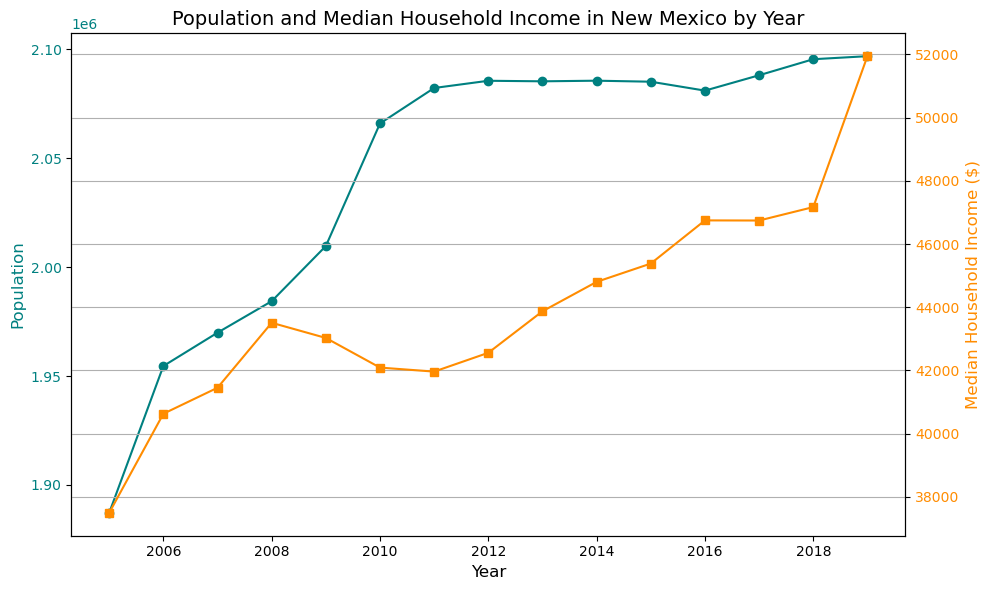

In [27]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(q2_df['year'], q2_df['pop'], color='teal', marker='o', label='Population')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Population', color='teal', fontsize=12)
ax1.tick_params(axis='y', labelcolor='teal')

ax2 = ax1.twinx()
ax2.plot(q2_df['year'], q2_df['income'], color='darkorange', marker='s', label='Median Income')
ax2.set_ylabel('Median Household Income ($)', color='darkorange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='darkorange')

plt.title('Population and Median Household Income in New Mexico by Year', fontsize=14)
fig.tight_layout()
plt.grid(True)
plt.show()

Looking at the graph, you can see that as average household income increases, so does population. It is reasonable to hypothesis that as population increases, the average household income does as well.

## Q3 - Student-defined Questions

# Question - What are the annual per capita incomes?

In [28]:
import pandas as pd

per_capita_sql = """
SELECT 
    i.year,
    i.income,
    p.pop,
    i.income::numeric / p.pop AS per_capita_income
FROM 
    public.income i
JOIN 
    public.population p ON i.fips = p.fips AND i.year = p.year
JOIN 
    public.name n ON i.fips = n.fips
WHERE 
    n.name = 'New Mexico'
ORDER BY 
    i.year;
"""

per_capita_df = pd.read_sql_query(per_capita_sql, con=conn)

print(per_capita_df)

    year  income      pop  per_capita_income
0   2005   37492  1887200           0.019866
1   2006   40629  1954599           0.020786
2   2007   41452  1969915           0.021043
3   2008   43508  1984356           0.021926
4   2009   43028  2009671           0.021410
5   2010   42090  2065932           0.020373
6   2011   41963  2082224           0.020153
7   2012   42558  2085538           0.020406
8   2013   43872  2085287           0.021039
9   2014   44803  2085572           0.021482
10  2015   45382  2085109           0.021765
11  2016   46748  2081015           0.022464
12  2017   46744  2088070           0.022386
13  2018   47169  2095428           0.022510
14  2019   51945  2096829           0.024773


/tmp/ipykernel_7771/545113142.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  per_capita_df = pd.read_sql_query(per_capita_sql, con=conn)


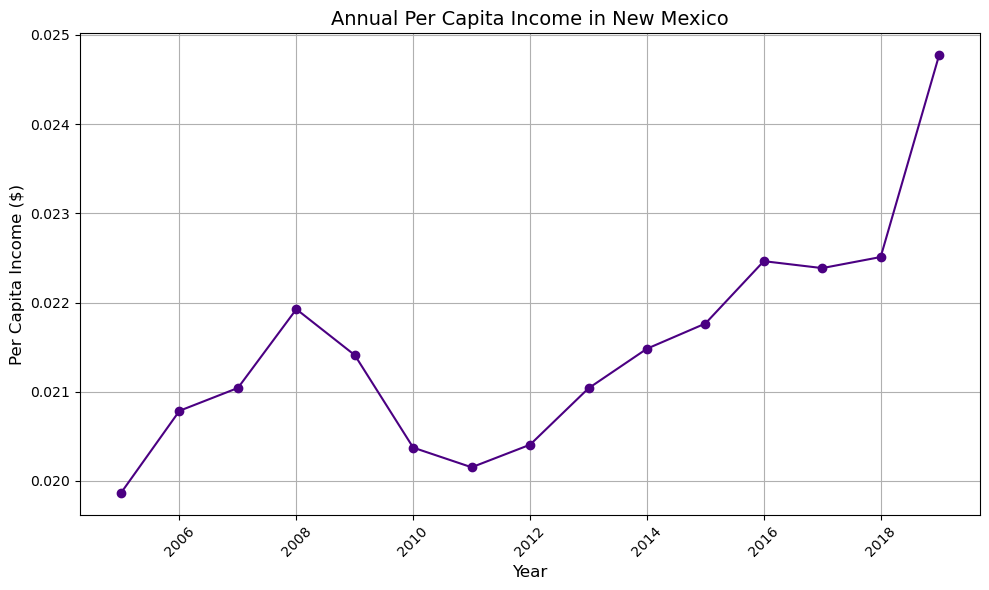

In [29]:
import matplotlib.pyplot as plt

# Create the line chart
plt.figure(figsize=(10, 6))
plt.plot(per_capita_df['year'], per_capita_df['per_capita_income'], marker='o', linestyle='-', color='indigo')

# Add labels and title
plt.title('Annual Per Capita Income in New Mexico', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Per Capita Income ($)', fontsize=12)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the chart
plt.show()

As seen in the graph, the average per capita income for the New Mexico population every year is an increase, but not a steady one. The data dips around 2011, when it then turns around and increases drastically in 2018.